<a href="https://colab.research.google.com/github/shivampip/Journey2AI/blob/master/ImageSegmentationTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Problem source](https://www.kaggle.com/c/carvana-image-masking-challenge)

In [0]:
import os
import glob
import zipfile
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from PIL import Image

In [0]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python import keras
from tensorflow.python.keras import backend as K

### Get all files

In [0]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

In [0]:
import kaggle

In [0]:
competition_name = 'carvana-image-masking-challenge'

In [0]:
# Download data from Kaggle and unzip the files of interest. 
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    print("getting train.zip")
    load_data_from_zip(competition, 'train.zip')
    print("getting train_masks")
    load_data_from_zip(competition, 'train_masks.zip')
    print("gettign train_masks.csv")
    load_data_from_zip(competition, 'train_masks.csv.zip')

In [16]:
get_data(competition_name)

getting train.zip
getting train_masks
gettign train_masks.csv


In [0]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [0]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [0]:
ls -R

In [61]:
df_train.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [62]:
ids_train.head()

0    00087a6bd4dc_01
1    00087a6bd4dc_02
2    00087a6bd4dc_03
3    00087a6bd4dc_04
4    00087a6bd4dc_05
Name: img, dtype: object

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
from sklearn.model_selection import train_test_split
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [65]:
print(len(x_train_filenames))
print(len(x_val_filenames))

4070
1018


In [66]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


In [67]:
print(x_train_filenames[:10])
print(y_train_filenames[:10])

['carvana-image-masking-challenge/train/69915dab0755_16.jpg', 'carvana-image-masking-challenge/train/695f39dfac16_04.jpg', 'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg', 'carvana-image-masking-challenge/train/562706000bd7_15.jpg', 'carvana-image-masking-challenge/train/917f262f1608_06.jpg', 'carvana-image-masking-challenge/train/fce0ba5b8ed7_07.jpg', 'carvana-image-masking-challenge/train/93881caf9f70_10.jpg', 'carvana-image-masking-challenge/train/eb07e3f63ad2_09.jpg', 'carvana-image-masking-challenge/train/78bfb9c780db_10.jpg', 'carvana-image-masking-challenge/train/d3d0d2662918_12.jpg']
['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif', 'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif', 'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif', 'carvana-image-masking-challenge/train_masks/562706000bd7_15_mask.gif', 'carvana-image-masking-challenge/train_masks/917f262f1608_06_mask.gif', 'carvana-image-masking-chall

In [0]:
from binarypipe import imagepipe as ip

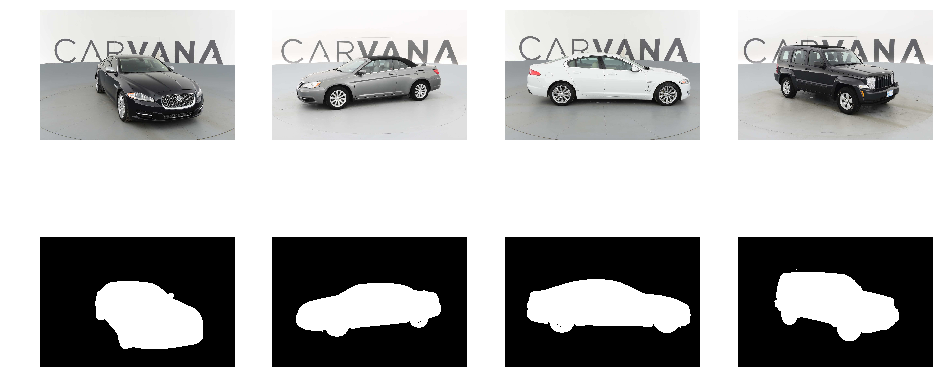

In [69]:
ip.plot(x_train_filenames[:4]+y_train_filenames[:4], count=-1, scale=2.0)

In [0]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5

**Processing pathnames**

In [0]:
def _process_pathnames(fpath, lpath):
    img_str= tf.read_file(fpath)
    img= tf.image.decode_jpeg(img_str, channels= 3)
    
    label_img_str= tf.read_file(lpath)
    label_img= tf.image.decode_gif(label_img_str)[0]
    label_img= label_img[:, :, 0]
    #print(label_img.shape)
    label_img= tf.expand_dims(label_img, axis= -1)
    #print(label_img.shape)
    return img, label_img

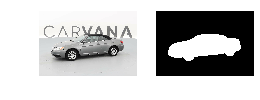

In [108]:
img, limg= _process_pathnames(x_train_filenames[1], y_train_filenames[1])
sess= K.get_session()
img, limg= sess.run((img, limg))
ip.plot([img, np.reshape(limg, (limg.shape[0], limg.shape[1]))])

**Shifting images**

In [0]:
def shift_image(img, limg, width_shift_range, height_shift_range):
    if(width_shift_range or height_shift_range):
        if(width_shift_range):
            width_shift_range= tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if(height_shift_range):
            height_shift_range= tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        
        img= tfcontrib.image.translate(img, [width_shift_range, height_shift_range])
        limg= tfcontrib.image.translate(limg, [width_shift_range, height_shift_range])
    return img, limg
        

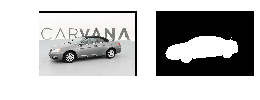

In [110]:
img, limg= shift_image(img, limg, 0.3, .3)
img, limg= sess.run([img, limg])
ip.plot([img, np.reshape(limg, (limg.shape[0], limg.shape[1]))])

**Flipping image randomly**

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

**Assembling all transformations**

In [0]:
def _augment(img,
             limg,
             resize= None,
             scale= 1.0,
             hue_delta= 0,
             horizontal_flip= False,
             width_shift_range= 0,
             height_shift_range= 0):
    if(resize is not None):
        img= tf.image.resize_images(img, resize)
        limg= tf.image.resize_images(limg, resize)
        
    if(hue_delta):
        img= tf.image.random_hue(img, hue_delta)
       
    img, limg= flip_img(horizontal_flip, img, limg)
    img, limg= shift_image(img, limg, width_shift_range, height_shift_range)
    
    img= tf.to_float(img) * scale
    limg= tf.to_float(img) * scale
    
    return img, limg

In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [0]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

W0626 09:10:03.749174 139995185522560 deprecation.py:323] From <ipython-input-125-461b49cb2dcf>:7: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


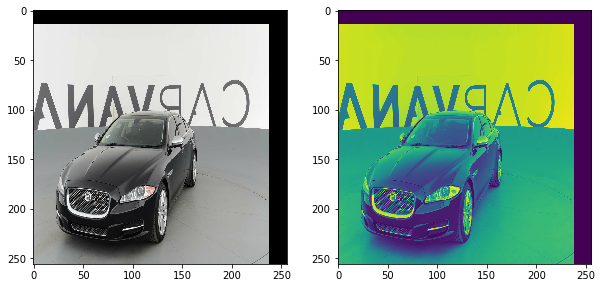

In [125]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

#### Build the Model

In [0]:
def conv_block(input_tensor, num_filters):
    encoder= keras.layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder= keras.layers.BatchNormalization()(encoder)
    encoder= keras.layers.Activation('relu')(encoder)
    encoder= keras.layers.Conv2D(num_filters, (3, 3), padding= 'same')(encoder)
    encoder= keras.layers.BatchNormalization()(encoder)
    encoder= keras.layers.Activation('relu')(encoder)
    return encoder

In [0]:
def encoder_block(input_tensor, num_filters):
    encoder= conv_block(input_tensor, num_filters)
    encoder_pool= keras.layers.MaxPool2D((2, 2), strides= (2, 2))(encoder)
    return encoder_pool, encoder